# Calculating post-match result probabilities using xG

I will essentially perform a Monte Carlo simulation of each match to predict the most probable outcomes. By comparing the xG of each shot in a match to the chance of scoring it at random, the probabilities of different scorelines in a match can be calculated. This is inspired by the [tutorial](http://fcpython.com/python-basics/random-with-xg) from FC Python. I will be using the StatsBomb [free data](https://statsbomb.com/academy/).

In [20]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import random
from collections import Counter
from highlight_text.htext import htext, fig_htext

import importing_sb as imsb

plt.style.use('football')

%matplotlib inline

## Importing data

In [3]:
data_dir = 'data/open-data/data/'

comp_data = imsb.open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(imsb.open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [368]:
import matplotlib as mpl
from cycler import cycler
from highlight_text.htext import htext, fig_htext

mpl.rcParams.update({'axes.titlesize':16,'axes.labelsize':14,'lines.linewidth':3,'lines.markersize':10,'lines.markeredgewidth':2})
mpl.rcParams.update({'font.family': ['sans-serif'],'font.sans-serif':['Arimo','Nunito','Helonia','Source Sans Pro',
                    'DejaVu Sans',
                    'Bitstream Vera Sans',
                    'Computer Modern Sans Serif',
                    'Lucida Grande',
                    'Verdana',                  
                    'Geneva',
                    'Lucid',
                    'Arial',
                    'Helvetica',
                    'Avant Garde',
                    'sans-serif']})
mpl.rcParams.update({'axes.prop_cycle':cycler('color', ['#004d98', '#edbb00', '#a50044', 'xkcd:green', 
                                                        '#8c564b', '#9467bd', '#e377c2', '#7f7f7f', 
                                                        '#bcbd22', '#17becf'])})

In [5]:
years = list(range(2018,2003,-1))
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [7]:
event_data = {}
for year in years:
    event_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))

In [8]:
shots = {}
for year in years:
    shots[str(year)] = [imsb.get_shots(match) for match in event_data[str(year)]]

In [9]:
scores = {}
for i in range(len(years)):
    scores[str(years[i])] = imsb.clean_match_data(match_data[i])

Get the home and away team, scores and xG (as calculated and provided by StatsBomb).

In [11]:
ht = {}; at = {}; hts = {}; ats = {}; h_shots = {}; a_shots = {};
for year in years:
    year = str(year)
    ht[year] = scores[year]['home_team']
    at[year] = scores[year]['away_team']
    hts[year] = scores[year]['home_score']
    ats[year] = scores[year]['away_score']
    h_shots[year] = [shots[year][i][shots[year][i]['team'] == ht[year][i]]['sb_xg'].values for i in range(len(shots[year]))]
    a_shots[year] = [shots[year][i][shots[year][i]['team'] == at[year][i]]['sb_xg'].values for i in range(len(shots[year]))]

Create function which simulates the number of goals scored for a given selection of shots by using a random number. If the random number is less than or equal to the xG then it is counted as a goal. This process is performed for the home and away teams' shots and repeated 10,000 times to smooth out any fluctuations. The function returns lists of the number of home and away goals scored in each simulation and the final (after 10,000 simulations) probabilities of home win, away win and draw.

In [13]:
def outcome_prob(h_shots,a_shots,sim_num=10000):
    hg = 0
    ag = 0
    h_goals = []
    a_goals = []
    h_win = 0
    a_win = 0
    draw = 0
    
    # Calculate number of goals from random chance given the xG values
    def find_goals(shots):
        goals = 0
        for shot in shots:
            if random.random() <= shot:
                goals += 1
        return goals
    
    # Loop over sim_num
    for i in range(sim_num):
        hg = find_goals(h_shots) # Number of home goals
        ag = find_goals(a_shots) # Number of away goals
        h_goals.append(hg) # List of all home goal totals
        a_goals.append(ag) # List of all away goal totals
        
        # Determine match outcome
        if hg > ag:
            h_win += 1
        elif ag > hg:
            a_win += 1
        else:
            draw += 1
    
    # Calculate probabilities of each outcome after sim_num simulations
    h_win = (h_win / sim_num) * 100
    a_win = (a_win / sim_num) * 100
    draw = (draw / sim_num) * 100
    
    return h_goals, a_goals, h_win, a_win, draw

As an example I use Messi's first match of the 18/19 season.

The plots below show the probability for each number of goals scored for each team, with the actual number scored highlighted in red.

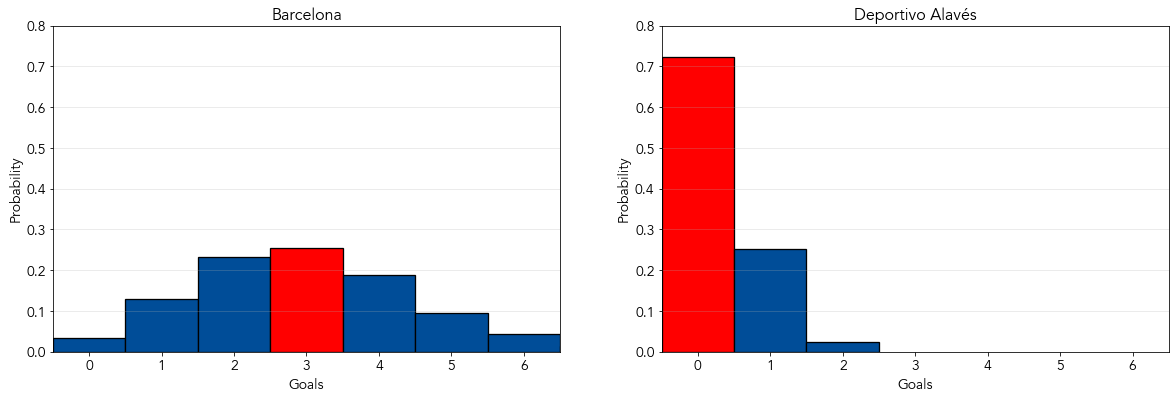

In [18]:
y = '2018' # Choose season
m = 0 # Choose match
h_goals, a_goals, *_ = outcome_prob(h_shots[y][m],a_shots[y][m])

max_val_tot = max(max(h_goals),max(a_goals))
max_val_h = max(h_goals)
max_val_a = max(a_goals)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
p1 = ax1.hist(h_goals,bins=max_val_h,density=True,align='left',ec='k')
p1[2][hts[y][m]].set_facecolor('r') # Colour the actual number of goals scored
ax1.set(xlim=(-0.5,6.5),ylim=(0,0.8),xlabel='Goals',ylabel='Probability',title='{}'.format(ht[y][m]))
ax1.grid(alpha=0.3,axis='y')

p2 = ax2.hist(a_goals,bins=max_val_a,density=True,align='left',ec='k')
p2[2][ats[y][m]].set_facecolor('r') # Colour the actual number of goals scored
ax2.set(xlim=(-0.5,6.5),ylim=(0,0.8),xlabel='Goals',ylabel='Probability',title='{}'.format(at[y][m]))
ax2.grid(alpha=0.3,axis='y')

plt.show()

I will now look at how Barcelona perform by calculating their expected amount of points, given the xG values of shots taken, and their actual points. The loop below does this for each season.

In [21]:
results = {}
for year in years:
    year = str(year)
    result = []
    hgP = []
    agP = []
    hP = []
    aP = []
    dP = []
    result_pred = []
    barca_result = []
    barca_pred = []
    for m in range(len(scores[year])):
        ht = scores[year]['home_team'][m]
        at = scores[year]['away_team'][m]
        hts = scores[year]['home_score'][m]
        ats = scores[year]['away_score'][m]
        h_shots = shots[year][m][shots[year][m]['team'] == ht]['sb_xg'].values
        a_shots = shots[year][m][shots[year][m]['team'] == at]['sb_xg'].values

        if hts > ats:
            result.append('h')
        elif ats > hts:
            result.append('a')
        else:
            result.append('d')

        h_goals, a_goals, h, a, d = outcome_prob(h_shots,a_shots)
        hgP.append(Counter(h_goals).most_common(1)[0][0])
        agP.append(Counter(a_goals).most_common(1)[0][0])
        hP.append(h)
        aP.append(a)
        dP.append(d)

        if (h > a) and (h > d):
            result_pred.append('h')
        elif (a > h) and (a > d):
            result_pred.append('a')
        elif (d > h) and (d > a):
            result_pred.append('d')
        else:
            result_pred.append(None)

    results[year] = pd.DataFrame()
    results[year]['home_team'] = scores[year]['home_team']
    results[year]['away_team'] = scores[year]['away_team']
    results[year]['home_score'] = scores[year]['home_score']
    results[year]['away_score'] = scores[year]['away_score']
    results[year]['home_score_pred'] = hgP
    results[year]['away_score_pred'] = agP
    results[year]['home_win_prob'] = hP
    results[year]['away_win_prob'] = aP
    results[year]['draw_prob'] = dP
    results[year]['result'] = result
    results[year]['pred'] = result_pred

    barca_h_points = results[year][results[year]['home_team'] == 'Barcelona']['result'].replace({'h':3,'d':1,'a':0})
    barca_a_points = results[year][results[year]['away_team'] == 'Barcelona']['result'].replace({'h':0,'d':1,'a':3})
    barca_h_points_pred = results[year][results[year]['home_team'] == 'Barcelona']['pred'].replace({'h':3,'d':1,'a':0})
    barca_a_points_pred = results[year][results[year]['away_team'] == 'Barcelona']['pred'].replace({'h':0,'d':1,'a':3})
    
    # Create new columns for the points and predicted points for Barca
    results[year] = results[year].join(pd.concat([barca_h_points,barca_a_points]).sort_index().rename('barca_points'))
    results[year] = results[year].join(pd.concat([barca_h_points_pred,barca_a_points_pred]).sort_index().rename('barca_pred'))

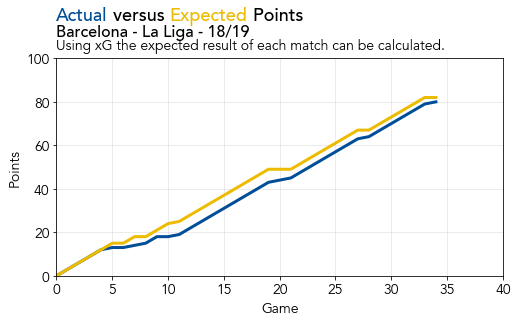

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(np.insert(results['2018']['barca_points'].values.cumsum(),0,0))
ax.plot(np.insert(results['2018']['barca_pred'].values.cumsum(),0,0))
ax.set(xlabel='Game',ylabel='Points',xlim=(0,40),ylim=(0,100))
ax.grid(alpha=0.3)
#ax.text(0.0,1.0,'')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Points',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - 18/19',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

Now look at how their actual points total has compared to the expected points total over the seasons.

In [26]:
barca_points_sum = np.array([results[str(year)]['barca_points'].sum() for year in years])
barca_pred_sum = np.array([results[str(year)]['barca_pred'].sum() for year in years])

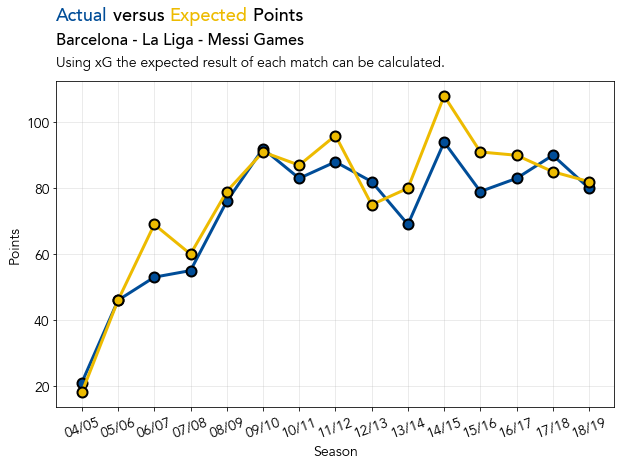

In [28]:
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
ind = np.flip((np.arange(len(years))))
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, barca_points_sum,'-o',mec='k')
ax.plot(ind, barca_pred_sum,'-o',mec='k')
ax.set(xticks=ind,xlabel='Season',ylabel='Points')
ax.set_xticklabels(seasons,rotation=20)
ax.grid(alpha=0.3)
#ax.text(0.0,1.0,'')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Points',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - Messi Games',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

For most seasons it seems that Barcelona were actually expected to get more points that they actually did. What is the reason for this? One answer could be the number of draws.

In [31]:
draws = [len(results[str(year)][results[str(year)]['barca_points'] == 1]) for year in years]
draws_pred = [len(results[str(year)][results[str(year)]['barca_pred'] == 1]) for year in years]

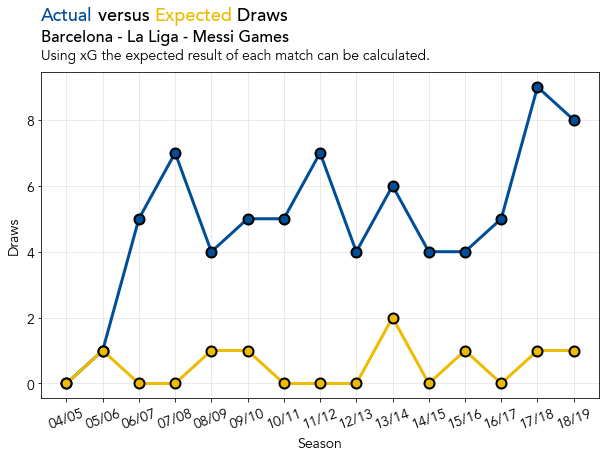

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, draws,'-o',mec='k')
ax.plot(ind, draws_pred,'-o',mec='k')
ax.set(xticks=ind,xlabel='Season',ylabel='Draws')
ax.set_xticklabels(seasons,rotation=20)
ax.grid(alpha=0.3)

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Draws',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - Messi Games',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

There are far more draws than predicted.